# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

In [4]:
# library = library_designer.design(
#     molecules = [deck[414]],
#     num_analogs = 600_000,
#     fraction_random = 0.0
# )
# library.annotations.to_csv(f'{path}/out/poised_414_analogs.csv')

Testing the best performing molecule from docking screen.

In [5]:
mol = dg.molecule.Molecule(
    'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
    reactants = [
        dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
        dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
    ]
)

analogs = library_designer.design(
    molecules = [mol],
    num_analogs = 20,
    fraction_random = 0.0
)

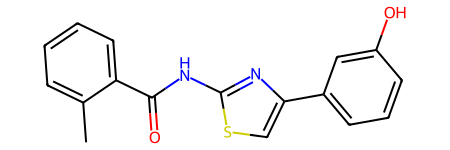

In [6]:
mol

In [7]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create molecular properties
# log_P_oracle = RDKitOracle('MolLogP')
# log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'{path}/Mpro_prepped.pdbqt',
    config=config
)

# create evaluators
# log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
# log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))
# docking_evaluator = ClassicEvaluator(ideal=(-12, -9), acceptable=(-12, -7))
docking_evaluator = ClassicEvaluator(ideal=(9, 12), acceptable=(7, 12))

# create utility function
utility_function = UtilityFunction(
    oracles = [
        docking_oracle,
        # log_S_oracle,
        # log_P_oracle
    ],
    evaluators = [
        docking_evaluator,
        # log_S_evaluator,
        # log_P_evaluator
    ],
    strategy = lambda x: np.prod(x, axis=0)
)

# utility = utility_function(deck)
# best_molecules = utility.argsort().tolist()[-25:]

In [8]:
results = docking_oracle(analogs)

In [14]:
sorted(results)

[-27.44,
 -20.082,
 -8.65634744713134,
 -7.479461545005596,
 -5.905384328022184,
 -4.07818509259582,
 -3.0559999999999996,
 -3.0394791808782577,
 1.758414312230397,
 2.524,
 3.427860500113154,
 3.533593082244328,
 3.8190852525173926,
 4.017432963944856,
 4.138969001769973,
 4.17993249530314,
 4.3758511807617255,
 4.471531181697015,
 4.523744540086455,
 4.586370087721609,
 4.666375040351641,
 4.777751605006833,
 4.893371543264079,
 4.929353295749523,
 4.990910893236181,
 5.069906086124502,
 5.202427792408354,
 5.227920852156827,
 5.253857679880406,
 5.273309719784477,
 5.335802600653553,
 5.343319977767546,
 5.354662517358225,
 5.355525318041746,
 5.362307354864516,
 5.389058011992782,
 5.499734861419588,
 5.514265085797619,
 5.538717857931774,
 5.567702343553837,
 5.611921789964118,
 5.644741479506155,
 5.647734654108251,
 5.6731745959252375,
 5.7040692113127385,
 5.723109124103094,
 5.774515550252566,
 5.793204800324832,
 5.79395453910346,
 5.7945300111411004,
 5.809310299935771,
 5.8

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


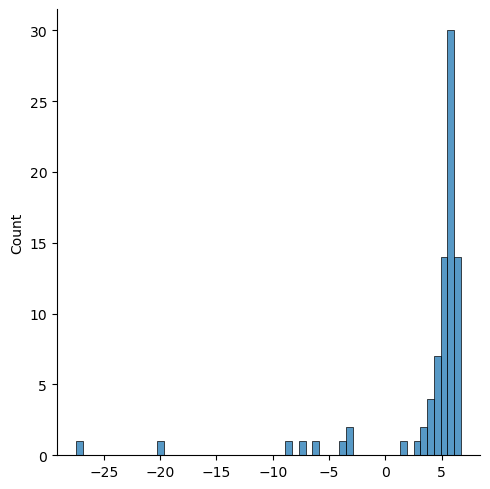

In [12]:
import seaborn as sns

sns.displot(results)